In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
#from library.sb_utils import save_file

In [428]:
df = pd.read_csv('../data/df_player_diffs.csv')
df.head()

,p_pts_won%,p_sv_pts_won%,p_ret_pts_won%,p_ace%,p_aced%,p_bp_save%,p_bp_convert%,t_id,t_date,tour_wk,...,p_tot_time_l6_diff,p_tot_time_l6_decay_diff,p_tot_pts_l6_diff,p_tot_pts_l6_decay_diff,p_matches_diff,p_stam_adj_fatigue_diff,p_stam_adj_fatigue_decay_diff,p_H2H_diff,high_t_ace_p_ace,high_t_ace_p_aced
0,47.84,56.28,38.41,1.09,3.66,55.00,43.75,2019-560,20190826,2019_24,...,-0.0,-0.0,-0.0,-0.0,-225.0,111.340206,83.505155,-0.0,0,0
1,41.29,49.40,31.94,4.82,15.28,33.33,40.00,2019-M014,20191014,2019_29,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,0,0
2,37.23,51.85,17.50,3.70,5.00,33.33,0.00,2019-M004,20190225,2019_07,...,-0.0,-0.0,-0.0,-0.0,-25.0,83.628319,62.721239,-0.0,0,0
3,59.14,69.23,46.34,3.85,4.88,100.00,37.50,2019-7696,20191105,2019_33,...,11.0,13.9,49.0,46.9,-80.0,104.593301,88.260500,0.0,0,1
4,53.66,70.77,34.48,7.69,3.45,88.89,37.50,2019-7696,20191105,2019_33,...,28.0,28.6,44.0,42.5,-18.0,53.118684,47.344561,0.0,0,1


In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36538 entries, 0 to 36537
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   p_pts_won%                                    36538 non-null  float64
 1   p_sv_pts_won%                                 36538 non-null  float64
 2   p_ret_pts_won%                                36538 non-null  float64
 3   p_ace%                                        36538 non-null  float64
 4   p_aced%                                       36538 non-null  float64
 5   p_bp_save%                                    36538 non-null  float64
 6   p_bp_convert%                                 36538 non-null  float64
 7   t_id                                          36538 non-null  object 
 8   t_date                                        36538 non-null  int64  
 9   tour_wk                                       36538 non-null 

In [430]:
df_filter = df[~df['tour_wk'].str.contains("2012")] 
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2013")]

In [431]:
# We will also remove BOTH players from individual matches remaining in the sample (after removing the earliest two years, where matches and stats accrued)
# where one player has played 3 or fewer matches prior to the one to be predicted on. 

df_low = df_filter.loc[df_filter['p_matches'] <= 25, 'm_num']
#df_low

df_filter = df_filter[~df_filter['m_num'].isin(df_low)]
df_filter

,p_pts_won%,p_sv_pts_won%,p_ret_pts_won%,p_ace%,p_aced%,p_bp_save%,p_bp_convert%,t_id,t_date,tour_wk,...,p_tot_time_l6_diff,p_tot_time_l6_decay_diff,p_tot_pts_l6_diff,p_tot_pts_l6_decay_diff,p_matches_diff,p_stam_adj_fatigue_diff,p_stam_adj_fatigue_decay_diff,p_H2H_diff,high_t_ace_p_ace,high_t_ace_p_aced
39,43.33,53.62,29.41,10.14,9.80,55.56,50.00,2019-0328,20191021,2019_30,...,-0.0,-0.0,-0.0,-0.0,-269.0,27.501630,20.626222,-0.0,0,0
40,45.07,61.11,28.57,2.78,14.29,60.00,20.00,2019-0429,20191014,2019_29,...,70.0,70.0,136.0,136.0,-90.0,76.905002,72.208666,-0.0,0,0
42,43.18,55.56,23.53,9.88,13.73,75.00,0.00,2019-0329,20190930,2019_27,...,-0.0,-0.0,-0.0,-0.0,-272.0,29.159699,21.869774,-0.0,0,0
43,42.74,56.36,30.65,10.91,11.29,50.00,16.67,2019-7581,20190923,2019_26,...,-0.0,-0.0,-0.0,-0.0,-273.0,29.731781,22.298836,-0.0,0,0
44,47.66,62.35,31.13,1.18,8.61,80.00,10.00,2019-560,20190826,2019_24,...,-61.0,-57.1,-45.0,-42.3,-41.0,33.464323,29.302865,-0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36507,42.95,54.44,27.27,3.33,9.09,42.86,50.00,2015-6003,20150928,2015_26,...,-0.0,-0.0,-0.0,-0.0,-143.0,22.780250,17.085188,-0.0,0,0
36508,45.15,60.36,27.37,6.31,13.68,70.00,0.00,2015-341,20150921,2015_25,...,-0.0,-0.0,-0.0,-0.0,-137.0,22.872443,17.154332,-0.0,0,0
36509,46.88,57.55,36.91,1.44,4.03,50.00,21.43,2015-560,20150831,2015_24,...,-0.0,-0.0,-0.0,-0.0,-163.0,24.894811,18.671108,-0.0,0,0
36510,50.93,66.67,34.91,12.96,3.77,60.00,25.00,2015-422,20150816,2015_22,...,-0.0,-0.0,-0.0,-0.0,-18.0,7.874416,5.905812,-0.0,0,0


In [432]:
#df_filter.info()

In [433]:
df_model1 = df_filter[["p_pts_won%", "p_opp_rank_diff", "p_opp_log_rank_diff", "p_opp_rank_pts_diff", "p_ent_diff", "p_opp_ht_diff", "p_opp_age_diff", "p_L_opp_R", "p_HCA_opp_N", "p_pts_won%_l70_decay_diff", "p_SOS_adj_pts_won%_l70_decay_diff", "p_sv_pts_won%_l70_decay_diff", "p_SOS_adj_sv_pts_won%_l70_decay_diff", "p_ret_pts_won%_l70_decay_diff", "p_SOS_adj_ret_pts_won%_l70_decay_diff", "p_sv_opp_ret_pts_won%_l70_decay_diff", "p_SOS_adj_sv_opp_ret_pts_won%_l70_decay_diff", "p_ret_opp_sv_pts_won%_l70_decay_diff", "p_SOS_adj_ret_opp_sv_pts_won%_l70_decay_diff", "p_ace%_l70_decay_diff", "p_SOS_adj_ace%_l70_decay_diff", "p_aced%_l70_decay_diff", "p_SOS_adj_aced%_l70_decay_diff", "p_ace%_opp_aced%_l70_decay_diff", "p_SOS_adj_ace%_opp_aced%_l70_decay_diff", "p_aced%_opp_ace%_l70_decay_diff", "p_SOS_adj_aced%_opp_ace%_l70_decay_diff", "p_bp_save%_l70_diff", "p_SOS_adj_bp_save%_l70_diff", "p_bp_convert%_l70_diff", "p_SOS_adj_bp_convert%_l70_diff", "p_bp_convert%_opp_bp_save%_l70_diff", "p_SOS_adj_bp_convert%_opp_bp_save%_l70_diff", "p_bp_save%_opp_bp_convert%_l70_diff", "p_SOS_adj_bp_save%_opp_bp_convert%_l70_diff", "p_tot_time_l6_diff", "p_tot_time_l6_decay_diff", "p_tot_pts_l6_diff", "p_tot_pts_l6_decay_diff", "p_matches_diff", "p_stam_adj_fatigue_diff", "p_stam_adj_fatigue_decay_diff", "p_H2H_diff", "high_t_ace_p_ace", "high_t_ace_p_aced"]]

In [464]:
df_model2 = df_filter[["p_pts_won%", "p_SOS_adj_pts_won%_l70_decay_diff"]]

In [465]:
X_train, X_test, y_train, y_test = train_test_split(df_model2.drop(columns='p_pts_won%'), 
                                                    df_model1["p_pts_won%"], test_size=0.3, 
                                                    random_state=47)

In [466]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [467]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [468]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [469]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000012A51531A60>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [470]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

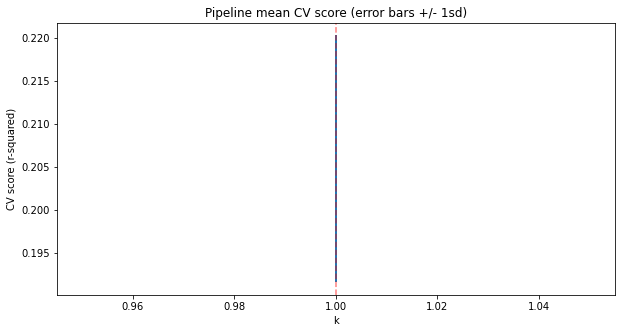

In [471]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [472]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.2029424 , 0.20585324, 0.1809386 , 0.21829641, 0.22164114])

In [473]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.20593436053805653, 0.014375461641016484)

In [474]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [475]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
#RMSE_LR_train

In [476]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
#RMSE_LR_test

In [477]:
RMSE_LR_train, RMSE_LR_test 

((5.700700352394936, 0.06117680364444042), 5.778971423421657)

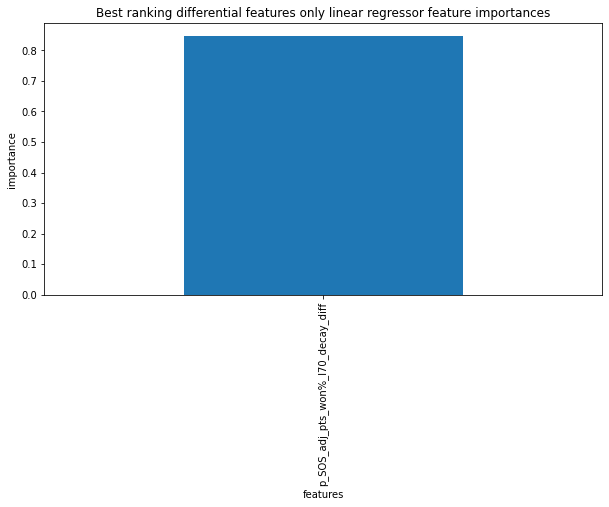

In [478]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

RMSE (%) (Training + STD), Test (25 match floor per player):

Exploring SOS Weighting on top of "Optimized" Time Decay Parameters (single feature RMSes), most to least predictive:

"p_SOS_adj_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1; 1x SOS Weight): (5.700700352394936, 0.06117680364444042), 5.778971423421657)
"p_SOS_adj_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1; sqrt SOS Weight): (5.708692563546904, 0.06409837090198885), 5.802719756424045)
"p_SOS_adj_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1; cbrt SOS Weight): (5.715906609976064, 0.06540572295841857), 5.815637300817043)

Pretty clear that full adjustment (ie, multiply by the ratio of field surface mean performance to opponent performance, superior to blunted adjustments. What about "enhancement adjustments"?

"p_SOS_adj_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1; 1x SOS Weight + or - additional 0.25% based on direction of ratio): (5.704716770355611, 0.061900467583257145), 5.773223888862516)

"p_SOS_adj_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1; 1x SOS Weight + or - additional delta% proportional to ratio): 

RMSE (%) (Training + STD), Test (25 match floor per player):

Exploring Past Performance Time-Decay Parameters (single feature RMSes), most to least predictive:

"p_SOS_adj_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1 weighting): (5.700700352394936, 0.06117680364444042), 5.778971423421657)   "p_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1 weighting): (5.739516448851719, 0.06811495670027151), 5.8510448099949794)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-8-4-2-2-1 weighting): (5.70139654452452, 0.06285361226791206), 5.777023104496484)     
"p_pts_won%_l60_decay_diff" (14-8-4-2-2-1 weighting): (5.742504039630257, 0.06994141890755766), 5.851226897611372)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-8-4-3-2-1 weighting): (5.701901001286776, 0.06293405157387694), 5.777519029055524      "p_pts_won%_l60_decay_diff" (14-8-4-3-2-1 weighting): (5.7412415738011635, 0.06968537050662564), 5.849878786368722

"p_SOS_adj_pts_won%_l60_decay_diff" (14-7-4-3-2-1 weighting): (5.701970996844204, 0.06338547652709513), 5.7779425016114345      "p_pts_won%_l60_decay_diff" (14-7-4-3-2-1 weighting): (5.741706254380049, 0.07047045743105043), 5.8504921523714275

"p_SOS_adj_pts_won%_l60_decay_diff" (14-8-3-3-2-1 weighting):(5.7021185324015295, 0.06405680749272107), 5.777102059700307)      "p_pts_won%_l60_decay_diff" (14-8-3-3-2-1 weighting): (5.742657601736909, 0.07095304803844815), 5.850889681087379)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-8-4-2-1-1 weighting): (5.7021682078429965, 0.06319673460792415), 5.775949208000239)     
"p_pts_won%_l60_decay_diff" (14-8-4-2-1-1 weighting): (5.745157415093033, 0.07062352714971437), 5.851563808230822)

"p_SOS_adj_pts_won%_l80_decay_diff" (14-8-4-2-2-1-1-1 weighting): (5.702393020079134, 0.0597361924428518), 5.784299350495121)   
"p_pts_won%_l80_decay_diff" (14-8-4-2-2-1-1-1 weighting): (5.739706857041751, 0.06721311467693547), 5.853220829989646)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-6-4-3-2-1 weighting): (5.702776826560398, 0.06397585869063308), 5.778887030111337      
"p_pts_won%_l60_decay_diff" (14-6-4-3-2-1 weighting): (5.742998670421851, 0.07130997484811558), 5.851991116383604

"p_SOS_adj_pts_won%_l60_decay_diff" (14-9-4-3-2-1 weighting): (5.702784578925794, 0.062424672911136986), 5.778130366497058)    "p_pts_won%_l60_decay_diff" (14-9-4-3-2-1 weighting): ((5.741784843813316, 0.0689629730263221), 5.85020825188207)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-8-5-3-2-1 weighting): (5.702877695170221, 0.061900761372265516), 5.779106899900872)      "p_pts_won%_l60_decay_diff" (14-8-5-3-2-1 weighting): (5.741007945905838, 0.068523174213746), 5.850047508814802)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-8-4-4-2-1 weighting): (5.7038264915546435, 0.0628865983615526), 5.779164736550989)     
"p_pts_won%_l60_decay_diff" (14-8-4-4-2-1 weighting): (5.7414739337685585, 0.06941173126210186), 5.849791595122807)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-10-4-3-2-1 weighting): (5.704028115859712, 0.062030077084789234), 5.779052029937065      "p_pts_won%_l60_decay_diff" (14-10-4-3-2-1 weighting): (5.7429506625744295, 0.06830025107309576), 5.85106440712119

"p_SOS_adj_pts_won%_l60_decay_diff" (14-5-4-3-2-1 weighting): (5.70445785241392, 0.06460534781377353), 5.780968645635956     
"p_pts_won%_l60_decay_diff" (14-5-4-3-2-1 weighting): (5.74557722826143, 0.07219751828056134), 5.8546056673978

"p_SOS_adj_pts_won%_l60_decay_diff" (13-5-4-3-2-1 weighting): (5.704606954547239, 0.06389554911713508), 5.78149940850968   
"p_pts_won%_l60_decay_diff" (13-5-4-3-2-1 weighting): (5.74406424521937, 0.07114820015571681), 5.853615431638814

"p_SOS_adj_pts_won%_l60_decay_diff" (15-5-4-3-2-1 weighting): (5.704647860337708, 0.06531589897169264), 5.78080336103432  
"p_pts_won%_l60_decay_diff" (15-5-4-3-2-1 weighting): (5.747371964141256, 0.07325995709869824), 5.8560661576834825

"p_SOS_adj_pts_won%_l60_decay_diff" (12-5-4-3-2-1 weighting): (5.705166286205211, 0.06309442319166643), 5.7826395157228685 
"p_pts_won%_l60_decay_diff" (12-5-4-3-2-1 weighting): (5.743077418571053, 0.07002963532332099)

"p_SOS_adj_pts_won%_l80_decay_diff" (14-8-4-2-2-2-1-1 weighting): (5.706168264234866, 0.059048591854832896), 5.789162346690146)  "p_pts_won%_l80_decay_diff" (14-8-4-2-2-2-1-1 weighting): (5.741704270031777, 0.06651454923985085), 5.855522737427849)

"p_SOS_adj_pts_won%_l60_decay_diff" (14-8-4-2-0-0 weighting): (5.706624466864698, 0.06454680627119862), 5.777018920598059)    
"p_pts_won%_l60_decay_diff" (14-8-4-2-0-0 weighting): (5.753549514613015, 0.07215489899215788), 5.8561518224076075)

"p_SOS_adj_pts_won%_l60_decay_diff" (10-5-4-3-2-1 weighting): (5.7089250319471345, 0.06123935853117713), 5.7869365646811834 
"p_pts_won%_l60_decay_diff" (10-5-4-3-2-1 weighting): (5.743276974052723, 0.06737970096929437)

"p_SOS_adj_pts_won%_l60_decay_diff" (20-5-4-3-2-1 weighting): (5.71054186006967, 0.06796747919176005), 5.784084351905588 
"p_pts_won%_l60_decay_diff" (20-5-4-3-2-1 weighting): (5.759898764202491, 0.07673429495161418), 5.866169315117677

"p_SOS_adj_pts_won%_l60_decay_diff" (8-5-4-3-2-1 weighting): (5.716890620182185, 0.059049443215608684), 5.795194028541858 
"p_pts_won%_l60_decay_diff" (8-5-4-3-2-1 weighting): (5.747507739672209, 0.06408952520269033), 5.85861437120536

"p_SOS_adj_pts_won%_l60_decay_diff" (6-5-4-3-2-1 weighting): (5.731459709895695, 0.05645462393504835), 5.809624387726638 
"p_pts_won%_l60_decay_diff" (6-5-4-3-2-1 weighting): (5.758148560597745, 0.06029004268171851), 5.869370616508432 

RMSE (%) (Training + STD), Test (25 match floor per player):

Comparing original (past 60 matches, 6-5-4-3-2-1) time decay-weighting of past performance "derivatives" with that calibrated on past % pts won (see above; past 70 matches, 14-8-4-2-2-1-1 per 10)

"p_SOS_adj_pts_won%_l60_decay_diff" (6-5-4-3-2-1 weighting): (5.731459709895695, 0.05645462393504835), 5.809624387726638 
"p_pts_won%_l60_decay_diff" (6-5-4-3-2-1 weighting): (5.758148560597745, 0.06029004268171851), 5.869370616508432
"p_SOS_adj_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1 weighting): (5.700700352394936, 0.06117680364444042), 5.778971423421657)    "p_pts_won%_l70_decay_diff" (14-8-4-2-2-1-1 weighting): (5.739516448851719, 0.06811495670027151), 5.8510448099949794)

"p_SOS_adj_sv_pts_won%_l60_decay_diff" (original): (6.024552159752249, 0.06373576362131024), 6.056051436512698)  
"p_sv_pts_won%_l60_decay_diff" (original): (6.088036449623465, 0.06563148341151175), 6.130072582568554)
"p_SOS_adj_sv_pts_won%_l70_decay_diff" (total pts% calibrated): (6.011110433430806, 0.06790767821594239), 6.042631320239675)  
"p_sv_pts_won%_l70_decay_diff" (total pts% calibrated): (6.0850760144820555, 0.07222366053715448), 6.127643839710211)

"p_SOS_adj_ret_pts_won%_l60_decay_diff" (original): (6.020952726711476, 0.05085827104198111), 6.113401042681634)
"p_ret_pts_won%_l60_decay_diff" (original): (6.1210907151642235, 0.05530239191436659), 6.228855199476289)
"p_SOS_adj_ret_pts_won%_l70_decay_diff" (total pts% calibrated): (6.010045325523975, 0.05051056009066952), 6.099657742155257)   
"p_ret_pts_won%_l70_decay_diff" (total pts% calibrated): (6.120139128934369, 0.054238678640792556), 6.225509660202439)

"p_SOS_adj_sv_opp_ret_pts_won%_l60_decay_diff"(original): (6.069520959103697, 0.0632404496504422), 6.139538611717908)
"p_sv_opp_ret_pts_won%_l60_decay_diff" (original): (6.148680477013504, 0.06895720244911273), 6.24212139670722
"p_SOS_adj_sv_opp_ret_pts_won%_l70_decay_diff" (total pts% calibrated): (6.059779697911127, 0.06547155166238024), 6.125885871554074)
"p_sv_opp_ret_pts_won%_l70_decay_diff" (total pts% calibrated): (6.146907565749973, 0.0693187507978504), 6.239566325853951)

"p_SOS_adj_ret_opp_sv_pts_won%_l60_decay_diff"(original): (6.069907780404034, 0.06885044494003323), 6.136524577330543)  
"p_ret_opp_sv_pts_won%_l60_decay_diff" (original): (6.154769368670694, 0.0675431388736644), 6.225044779584807) 
"p_SOS_adj_ret_opp_sv_pts_won%_l70_decay_diff" (total pts% calibrated): (6.058066294377293, 0.0719230901499359), 6.127665462802234)   
"p_ret_opp_sv_pts_won%_l70_decay_diff" (total pts% calibrated):(6.152380349626899, 0.07229218934232279), 6.2241216668287676)

"p_SOS_adj_ace%_l60_decay_diff" (original): (6.373688609938726, 0.05917045620467138), 6.429725242782088) 
"p_ace%_l60_decay_diff" (original): (6.378513519549024, 0.058346185006277106), 6.4377768884677495)
"p_SOS_adj_ace%_l70_decay_diff" (total pts% calibrated): (6.37185520370761, 0.059448099390134304), 6.428902356956003)  
"p_ace%_l70_decay_diff" (total pts% calibrated): (6.377294626338432, 0.05887167407227668), 6.437813890167375)

"p_SOS_adj_aced%_l60_decay_diff" (original): (6.2325463496101365, 0.026220526703780448), 6.319544074012746)
"p_aced%_l60_decay_diff" (original): (6.294983981489251, 0.03613982499323277), 6.39199509526103) 
"p_SOS_adj_aced%_l70_decay_diff" (total pts% calibrated): (6.229250660895607, 0.02797884871693028), 6.3121389946227415)  
"p_aced%_l70_decay_diff" (total pts% calibrated): (6.292769450295713, 0.03538285989371251), 6.389753235514651)

"p_SOS_adj_ace%_opp_aced%_l60_decay_diff" (original): (6.399639307114217, 0.05735832622923495), 6.470796566098023) 
"p_ace%_opp_aced%_l60_decay_diff" (original): (6.400043034141925, 0.05743667361669816), 6.469964472239747)
"p_SOS_adj_ace%_opp_aced%_l70_decay_diff" (total pts% calibrated): (6.399309990256652, 0.0572521763318927), 6.471281151205022)  "p_ace%_opp_aced%_l70_decay_diff" (total pts% calibrated): (6.40006182354782, 0.057390467651575475), 6.470005513950027)

"p_SOS_adj_aced%_opp_ace%_l60_decay_diff" (original): (6.399941211067464, 0.05796713510936121), 6.468449720974379)
"p_aced%_opp_ace%_l60_decay_diff" (original): (6.399616522954298, 0.05838725493174678), 6.4684682730595675)
"p_SOS_adj_aced%_opp_ace%_l70_decay_diff" (total pts% calibrated): (6.40006182354782, 0.057390467651575475), 6.470005513950027)  "p_aced%_opp_ace%_l70_decay_diff" (total pts% calibrated): (6.39961871348561, 0.058393637132973165), 6.4686103724201125)

"p_SOS_adj_bp_save%_l60_diff" (original): (6.28843068563915, 0.05764328910686724), 6.331759188999865)
"p_bp_save%_l60_diff" (original): (6.3162318748899215, 0.05468561872472459), 6.369346338544005)
"p_SOS_adj_bp_save%_l70_diff" (total pts% calibrated): (6.278196497712368, 0.05770214783025755), 6.328105378190756)  
"p_bp_save%_l70_diff" (total pts% calibrated): (6.308861347978732, 0.054988376286133775), 6.364838339444989)

"p_SOS_adj_bp_convert%_l60_diff" (original): (6.254769449926188, 0.06438192754188947), 6.344697991538532)
"p_bp_convert%_l60_diff" (original): (6.291052900403863, 0.05965182641571441), 6.3830353195277745)
"p_SOS_adj_bp_convert%_l70_diff" (total pts% calibrated): (6.247731546934557, 0.06291782275271879), 6.344071904152056) 
"p_bp_convert%_l70_diff" (total pts% calibrated): (6.288051470070291, 0.05888776567262881), 6.383189205138553)

"p_SOS_adj_bp_convert%_opp_bp_save%_l60_diff" (original): (6.310781264813318, 0.05030257389838921), 6.378230322011208)
"p_bp_convert%_opp_bp_save%_l60_diff" (original): (6.310781264813318, 0.05030257389838921), 6.378230322011208)
"p_SOS_adj_bp_convert%_opp_bp_save%_l70_diff" (total pts% calibrated): (6.306154277608987, 0.048901572301457245), 6.374878301708185)  
"p_bp_convert%_opp_bp_save%_l70_diff" (total pts% calibrated): (6.306154277608987, 0.048901572301457245), 6.374878301708185)

"p_SOS_adj_bp_save%_opp_bp_convert%_l60_diff" (original): (6.274678518891621, 0.06947919789903892), 6.340609701128036)
"p_bp_save%_opp_bp_convert%_l60_diff" (original): (6.307852620645132, 0.06640760761196812), 6.38365012203657)
"p_SOS_adj_bp_save%_opp_bp_convert%_l70_diff" (total pts% calibrated): (6.265915584952545, 0.07007947052701771), 6.339846072292388)   
"p_bp_save%_opp_bp_convert%_l70_diff" (total pts% calibrated): (6.3018042875749725, 0.0665676489501543), 6.383387981652603)



RMSE (%) (Training + STD), Test (25 match floor per player):

Tweaking Fatigue and Stamina Parameters (single feature RMSes)

Total pts over past 5 same tournament matches, most to least predictive:
"p_tot_pts_l5_diff" (25 pts fill): (6.229683910439677, 0.03492561963722004), 6.310126448785985 
"p_tot_pts_l5_decay_diff"(25 fill): (6.235626295093118, 0.034993478091310544), 6.31050141816948 
"p_tot_pts_l5_diff" (0 fill): (6.236547824121212, 0.034718669213771675), 6.316191191465449
"p_tot_pts_l5_decay_diff" (0 fill): (6.242260489358559, 0.034628084939723414), 6.3166482270577315
"p_tot_pts_l5_diff" (50 fill): (6.236547824121212, 0.034718669213771675), 6.316191191465449
"p_tot_pts_l5_decay_diff" (50 fill): (6.242260489358559, 0.034628084939723414), 6.3166482270577315 
"p_tot_pts_l5_diff" (100 fill): (6.272131355824987, 0.03784560249552935), 6.348478108736114  
"p_tot_pts_l5_decay_diff"(100 fill): (6.276597937498432, 0.037516629910509296), 6.348790960488024
"p_tot_pts_l5_diff" (150 fill): (6.336737149364769, 0.04681117547593419), 6.408151145924376 
"p_tot_pts_l5_decay_diff"(150 fill): (6.338298366412539, 0.04636515584317224), 6.407203574125375

Total time over past 5 same tournament matches, most to least predictive:
"p_tot_time_l5_diff (0 min fill)": (6.2484295845557005, 0.03661107978019508), 6.323007365237594
"p_tot_time_l5_decay_diff" (0 fill): (6.254944978387288, 0.03567345656673734), 6.323253574894165
"p_tot_time_l5_diff (15 fill)": (6.253367509042231, 0.0361097523756986), 6.326876261077702 
"p_tot_time_l5_decay_diff" (15 fill): (6.259771609822131, 0.03501656421117225), 6.327175483576264 
"p_tot_time_l5_diff (30 fill)": (6.2615638867556775, 0.03596784435287501), 6.3337629417095345
"p_tot_time_l5_decay_diff" (30 fill): (6.267735582409725, 0.03475996894647597), 6.3341164721604475
"p_tot_time_l5_diff (60 fill)": (6.291520672297674, 0.03788822530175488), 6.360592580094662
"p_tot_time_l5_decay_diff" (60 fill): (6.296480077886196, 0.036710733966044046), 6.360783961425041

Stamina Adjusted Fatigue (improves on using points played alone, the numerator here, in all variants using pts instead of time)
"p_stam_adj_fatigue_diff" (25 pts fill; 4th rt of p_matches): (6.154984536814284, 0.033519260679442255), 6.229254663710725
"p_stam_adj_fatigue_decay_diff" (25 pts fill; 4th rt of p_matches): (6.163984029385444, 0.033965380720726704),  6.232783224981465
"p_stam_adj_fatigue_diff" (25 pts fill; 5th rt of p_matches): (6.1587502171854585, 0.032675252967922716), 6.2341884371200145
"p_stam_adj_fatigue_decay_diff" (25 pts fill; 5th rt of p_matches): (6.169194200376327, 0.03323913423189109), 6.239055575714976
"p_stam_adj_fatigue_diff" (25 pts fill; cbrt of p_matches): (6.155879370384608, 0.03555082774221991), 6.228378246212155 
"p_stam_adj_fatigue_decay_diff" (25 pts fill; cbrt of p_matches): (6.162142824591838, 0.0357138387134125), 6.229421474941257 
"p_stam_adj_fatigue_diff" (25 pts fill; sqrt of p_matches): (6.172426915074166, 0.04088497018573209), 6.24133244639224
"p_stam_adj_fatigue_decay_diff" (25 pts fill; sqrt of p_matches): (6.174500361112566, 0.04053440487729867), 6.2388293120074305 

SAF: Taking optimal from immediately above (25 pts fill; 4th root of p_matches, but playing with decay fxn params)
"p_stam_adj_fatigue_diff" (equal weight all 5 matches): (6.154984536814284, 0.033519260679442255), 6.229254663710725
"p_stam_adj_fatigue_diff" (1,.9,.8,.7,.6): (6.157262884249155, 0.033580141939803104), 6.229080524144005)
"p_stam_adj_fatigue_decay_diff" (1,.8,.6,.4,.2): (6.163984029385444, 0.033965380720726704),  6.232783224981465
"p_stam_adj_fatigue_decay_diff" (same ratios as perfomance decay): (6.17747327448653, 0.034785772246625296), 6.244595021955058)

Pretty convinced that no time decay yields the best prediction quality. Now what about bumping it up to 6 prior matches? (most that can have in on tourney prior to a given match).

"p_stam_adj_fatigue_diff" (equal weight all 6 matches): (6.150559220909935, 0.03380319490789776), 6.223804848602433)
Does perform slightly better than only using 5 matches. Will switch to using 6, which is the max for a given tourney. 





RMSE (%) (Training + STD), Test (25 match floor per player):

High T Ace & High P Ace (single feature RMSes)
+ .35 Tourney SD/+ .4 Player SD Thresholds for a 1: (6.39727877230224, 0.05648242171181078), 6.463708665234474)
+ .4 Tourney SD/+ .4 Player SD Thresholds for a 1: (6.397641756984077, 0.05674463632372665), 6.4628048324153005)
+ .3 Tourney SD/+ .4 Player SD Thresholds for a 1: (6.397684013711354, 0.056562504199569714), 6.463736656754845)
+ .5 Tourney SD/+ .5 Player SD Thresholds for a 1: (6.3977423056365925, 0.057380777843227565), 6.463717062090251)
+ .3 Tourney SD/+ .5 Player SD Thresholds for a 1: (6.397750958370724, 0.05641197346972552), 6.463624370087483)
+ .35 Tourney SD/+ .35 Player SD Thresholds for a 1: (6.397912733132824, 0.05613959498874378), 6.464141057359893)
+ .4 Tourney SD/+ .3 Player SD Thresholds for a 1: (6.398048856224546, 0.056387756455348624), 6.463494959384604)
+ .5 Tourney SD/+ .3 Player SD Thresholds for a 1: (6.3980718294274554, 0.0572189686515367), 6.463757982189166)
+ .3 Tourney SD/+ .3 Player SD Thresholds for a 1: (6.398191616790472, 0.056222868878117276), 6.464199778131374)
+ .3 Tourney SD/+ .35 Player SD Thresholds for a 1: (6.39828347649353, 0.05629646146221094), 6.464277132765515)

RMSE (%) (Training + STD), Test (25 match floor per player):

High T Ace & High P Aced (single feature RMSes)
+ .3 Tourney SD/+ .3 Player SD Thresholds for a 1: (6.3839594274863085, 0.05788569835751363), 6.46241731731097)
+ .3 Tourney SD/+ .35 Player SD Thresholds for a 1: (6.385079012674781, 0.057892326302334), 6.462765855544612)
+ .35 Tourney SD/+ .4 Player SD Thresholds for a 1: (6.385079012674781, 0.057892326302334), 6.462765855544612)
+ .3 Tourney SD/+ .4 Player SD Thresholds for a 1: (6.385492249760566, 0.05871096740510958), 6.463850917847346)
+ .35 Tourney SD/+ .35 Player SD Thresholds for a 1: (6.386196549768895, 0.05662989954352045), 6.461672827293747)
+ .2 Tourney SD/+ .2 Player SD Thresholds for a 1: (6.386401175805619, 0.056489962606164665), 6.457548590435539)
+ .4 Tourney SD/+ .3 Player SD Thresholds for a 1: (6.386938751696779, 0.05626289795229288), 6.4625604655190285)
+ .4 Tourney SD/+ .4 Player SD Thresholds for a 1: (6.38755221599672, 0.057345163732406515), 6.464187593207696)
+ .3 Tourney SD/+ .5 Player SD Thresholds for a 1: (6.388456279423919, 0.05955014832251633), 6.464141232768423)
+ .5 Tourney SD/+ .3 Player SD Thresholds for a 1: (6.39096264961245, 0.058572853593726694), 6.465678054356053)
+ .5 Tourney SD/+ .5 Player SD Thresholds for a 1: (6.39096264961245, 0.058572853593726694), 6.465678054356053)